In [1]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord

mpl.rcParams['axes.labelsize']=35
%matplotlib inline

plt.style.use('seaborn-colorblind')

In [2]:
catalog_id = pd.read_csv('/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/stars_accretion_history_m12i_res7100_v2.csv',
                     usecols = ['id_stars'])

In [3]:
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced.hdf5'

In [4]:
with h5py.File(path, 'r') as f:
    ananke_id = f['source_id'][:]

In [5]:
accretion_id = np.isin(ananke_id, catalog_id)

In [6]:
accretion = np.int32(accretion_id)

In [7]:
is_accreted = accretion

In [8]:
with h5py.File(path, 'a') as f:
#     del f['is_accreted']
    f.create_dataset('is_accreted', data=accretion)

In [5]:
#ZM cut labels
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/AnankeDR3_data_reduced_m12f_lsr1.hdf5'
with h5py.File(path, 'r') as f:
    rv = f['radial_velocity'][:]
    ra = f['ra'][:]
    dec = f['dec'][:]
    pmra = f['pmra'][:]
    pmdec = f['pmdec'][:]
    parallax = f['parallax'][:]
    feh = f['feh'][:]
    source_id = f['parentid'][:]

In [6]:
keep_source_id = source_id
empt = np.zeros(len(keep_source_id))

ra = ra * u.deg
dec = dec * u.deg
pmra = pmra * u.mas / u.yr
pmdec = pmdec * u.mas / u.yr
parallax = parallax * u.mas
rv = rv * u.km / u.s

dist = coord.Distance(parallax=parallax, allow_negative=True)

# Coord transformation
icrs = coord.ICRS(
    ra=ra, dec=dec, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv)
gal = icrs.transform_to(coord.Galactocentric())
x_gal = gal.x.to_value(u.kpc)
y_gal = gal.y.to_value(u.kpc)
z_gal = gal.z.to_value(u.kpc)
vx_gal = gal.v_x.to_value(u.km/u.s)
vy_gal = gal.v_y.to_value(u.km/u.s)
vz_gal = gal.v_z.to_value(u.km/u.s)  

z_mask = (np.absolute(z_gal) > 1.5)
source_id = source_id[z_mask]
vx = vx_gal[z_mask]
vy = vy_gal[z_mask]
vz = vz_gal[z_mask]
feh = feh[z_mask]

feh_mask = (feh < -1.5)
source_id = source_id[feh_mask]
vx = vx[feh_mask]
vy = vy[feh_mask]
vz = vz[feh_mask]
feh = feh[feh_mask]

accretion_id = np.isin(keep_source_id, source_id)
accretion = np.int32(accretion_id)
is_accreted = accretion

with h5py.File(path, 'a') as f:
    # del f['is_accreted']
    f.create_dataset('is_accreted', data=accretion)

In [11]:
# with h5py.File(path, 'r') as f:
#     is_accreted = f['is_accreted'][:]

In [12]:
mask0 = (is_accreted==0)
mask1 = (is_accreted==1)

In [13]:
with h5py.File(path, 'r') as f:
    vx = f['vx_true'][:]
    vy = f['vy_true'][:]
    vz = f['vz_true'][:]

vx0 = vx[mask0]
vy0 = vy[mask0]
vz0 = vz[mask0]
vr0 = np.sqrt(vx0**2+vz0**2)

vx1 = vx[mask1]
vy1 = vy[mask1]
vz1 = vz[mask1]
vr1 = np.sqrt(vx1**2+vz1**2)

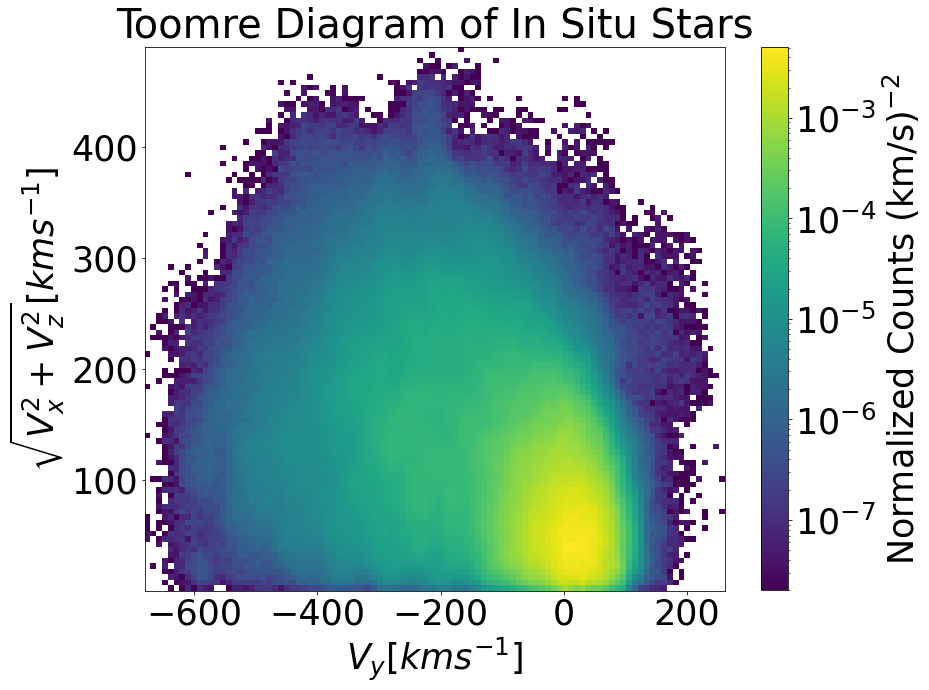

In [14]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy0, vr0, bins=100, weights=np.repeat(1/len(vx0), len(vx0)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=35)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=35)
ax.set_title('Toomre Diagram of In Situ Stars', fontsize=40)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=35)
ax.tick_params(axis='both', labelsize=35)

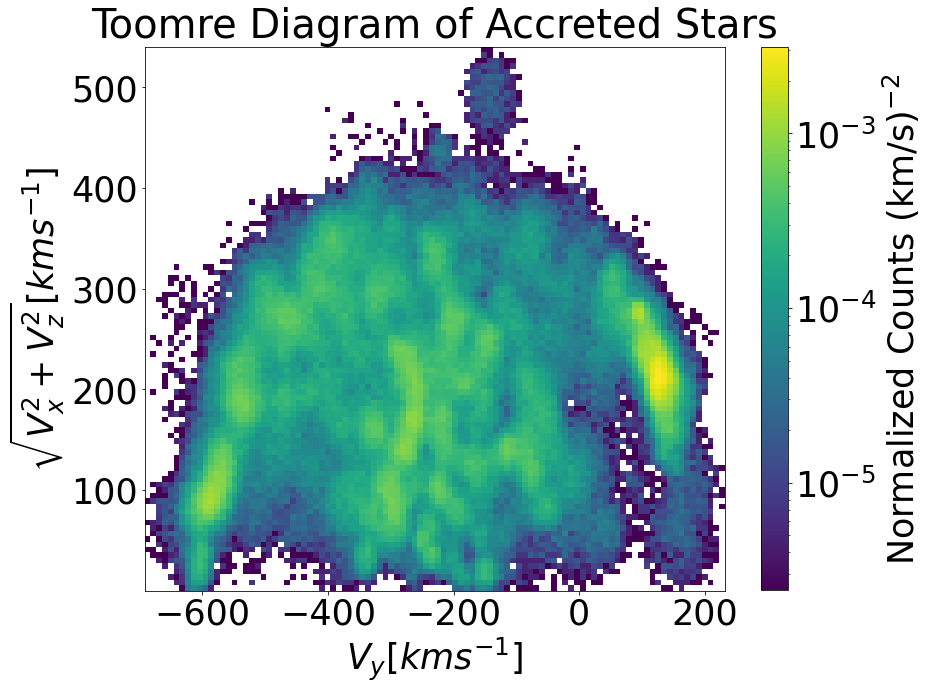

In [15]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy1, vr1, bins=100, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=35)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=35)
ax.set_title('Toomre Diagram of Accreted Stars', fontsize=40)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=35)
ax.tick_params(axis='both', labelsize=35)

In [16]:
# fig, ax = plt.subplots(1, figsize=(13, 10))

# h = ax.hist2d(vy1, vr1, bins=100, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
# ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=20)
# ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=20)
# ax.set_title('Toomre Diagram of Accreted Stars', fontsize=30)
# cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$')

# cb.ax.tick_params(labelsize=20)

In [17]:
# fig, ax = plt.subplots(1, figsize=(10, 10))

# ax.hist2d(vy1, vr1, bins=100, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
# ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=20)
# ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=20)
# ax.set_title('Toomre Diagram of Accreted Stars')
# ax.colorbar(label=r'counts (km/s)$^{-2}$', lan)
# ax.show()

In [18]:
with h5py.File(path, 'r') as f:
    feh = f['feh'][:]
    
feh0 = feh[mask0]
feh1 = feh[mask1]

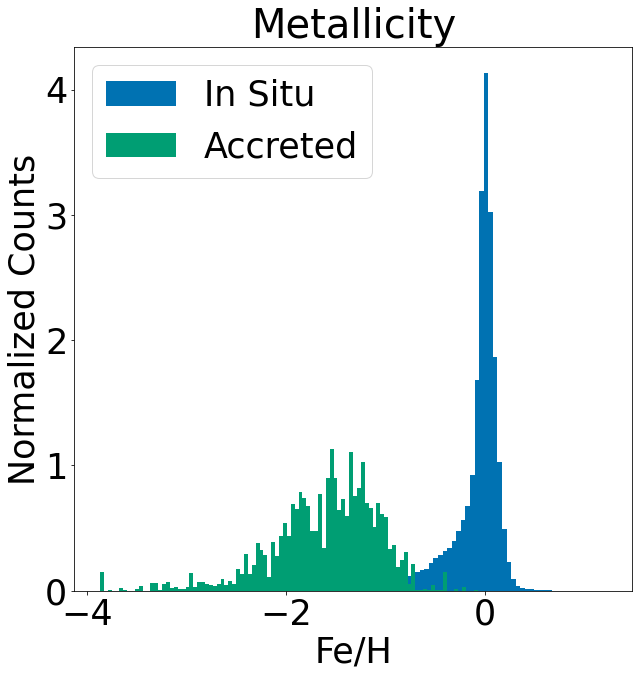

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(feh0, bins=100, density=True, label='In Situ')
ax.hist(feh1, bins=100, density=True, label='Accreted')
ax.set_title('Metallicity', fontsize=40)
ax.set_xlabel('Fe/H', fontsize=35)
ax.set_ylabel('Normalized Counts', fontsize=35)
ax.tick_params(axis='both', labelsize=35)
ax.legend(loc='upper left', fontsize=35)